# Explanatory images analysis

### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from PIL import Image

import itertools

import os

### Image types

In [2]:
df = pd.read_csv('data/private_info/train.csv', sep = '\t')
print(df.shape[0])
df.head()

5277


,image_name,label_id
0,good_cigs_000403.jpg,1
1,sigars_000289.jpg,1
2,sigars_000276.jpg,1
3,sigars_000262.jpg,1
4,sigars_000048.jpg,1


label_id
0    3363
1    1914
Name: count, dtype: int64


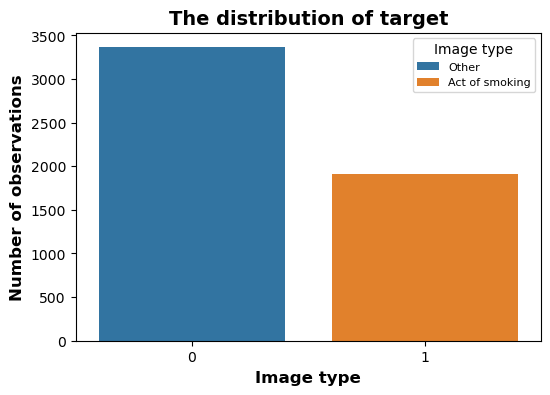

In [3]:
print(df['label_id'].value_counts() )

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('The distribution of target', fontsize=14,fontweight="bold")

plt.xlabel('Image type',  fontsize=12, fontweight="bold")
plt.ylabel('Number of observations',  fontsize=12, fontweight="bold")
sns.countplot( data = df, x = 'label_id' ,ax = ax, hue = 'label_id');
plt.legend(title='Image type', labels=[ 'Other', 'Act of smoking'], title_fontsize=10, fontsize=8
         );

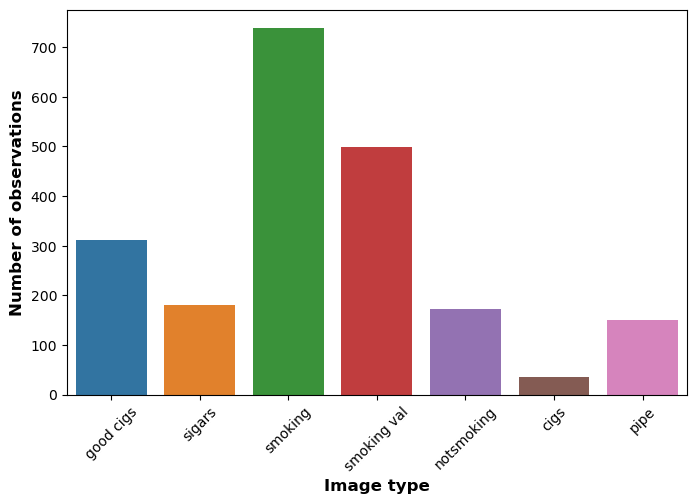

In [4]:
df['image_type'] = df['image_name'].str.split(r"(_\d+)", regex = True).str[0]
df['image_type'] = df['image_type'].str.replace('_', ' ')
df['image_type'] = np.where(df['image_type'].str.contains(r'(\d+)'), 'others', df['image_type'] )

dff = df[~df.image_type.isin(['others', 'default railway.jpg']) ]
fig, ax = plt.subplots(figsize=(8, 5))


plt.xlabel('Image type',  fontsize=12, fontweight="bold")
plt.ylabel('Number of observations',  fontsize=12, fontweight="bold")
sns.countplot( data = dff, x = 'image_type' ,ax = ax, hue = 'image_type');
plt.xticks(rotation=45);


### Images features

In [6]:
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

def brightness(image):
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
    return np.array(image).mean()

def calculate_contrast(image):
     image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
     return np.array(image).std()

def calculate_color_distribution(image):
    color_distribution = {'R': [], 'G': [], 'B': []}
    
    color_distribution['R'].append(np.mean(image[:,:,0]))
    color_distribution['G'].append(np.mean(image[:,:,1]))
    color_distribution['B'].append(np.mean(image[:,:,2]))
    return color_distribution

In [17]:
def load_images(folder:str ):
    path = 'data/train/' + folder
    img_names_list = os.listdir(path)
    sharpness_list = []
    contrast_list = []
    bright_list = []
    rgb_r = []
    rgb_g = []
    rgb_b = []
    folders = []
    for i in img_names_list:
        path_img = 'data/train/' + folder + '/'+ i 
        img = cv2.imread(path_img)
        sharpness_list.append(variance_of_laplacian(img ) )
        contrast_list.append(calculate_contrast(img))
        bright_list.append(brightness(img))
        rgb_r.append(calculate_color_distribution(img)['R'][0])
        rgb_g.append(calculate_color_distribution(img)['G'][0])
        rgb_b.append(calculate_color_distribution(img)['B'][0])

        
        del img
        folders.append(folder)
    df = {'image_id':  img_names_list,'category': folder, 'sharpness' : sharpness_list, 
          'contrast' : contrast_list, 'bright' : bright_list, 
          'rgb_red' : rgb_r,
          'rgb_green': rgb_g,
          'rgb_blue' : rgb_b
          }

    return pd.DataFrame(df)
        




In [18]:
%%time

categories = os.listdir('train/')
final_df = pd.DataFrame()
for category in categories:
    df  =  load_images(category)
    final_df = pd.concat([final_df, df])

CPU times: total: 8min 41s
Wall time: 8min 49s


In [41]:
final_df['target'] = np.where(final_df['category'] == 'other', 0, 1 )

In [42]:
final_df.to_excel("images_features.xlsx")

In [43]:
final_df.head()

,image_id,category,sharpness,contrast,bright,rgb_red,rgb_green,rgb_blue,target
0,cigs_1_000037.jpg,cigs,20.119542,36.140045,24.449738,23.644596,24.670447,25.445756,1
1,cigs_1_000040.jpg,cigs,167.245179,58.429170,234.032241,230.721892,235.131748,237.255541,1
2,cigs_1_000045.jpg,cigs,789.133910,53.230679,129.982296,128.695938,129.858656,134.105696,1
3,cigs_1_000048.jpg,cigs,122.197717,68.937343,129.800651,129.377978,131.317845,123.210509,1
4,cigs_1_000050.jpg,cigs,8.433766,89.403778,124.906648,120.159795,125.669862,133.532245,1


In [44]:
final_df.describe()

,sharpness,contrast,bright,rgb_red,rgb_green,rgb_blue,target
count,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000,3302.000000
mean,722.571219,62.220777,160.013553,155.848550,160.665850,167.715503,0.359479
std,1204.289396,20.474112,62.207317,64.531414,62.491656,61.303163,0.479920
min,1.367567,5.458423,4.951322,3.878354,4.588537,6.524319,0.000000
25%,142.754245,48.022276,109.333552,101.463628,110.647860,118.868630,0.000000
50%,351.763787,62.291253,170.107529,167.045668,171.478171,181.018956,0.000000
75%,805.547230,76.395107,214.937791,213.253421,215.562616,221.282108,1.000000
max,17182.219874,118.013656,253.891688,254.242033,253.946959,254.738736,1.000000


In [47]:
final_df.groupby('target').describe().T

target                      0             1
sharpness count   2115.000000   1187.000000
          mean     744.779090    683.001169
          std     1222.922285   1169.818628
          min        1.367567      4.239648
          25%      127.821659    165.947473
          50%      364.765669    338.068598
          75%      860.755849    690.070940
          max    17182.219874  15530.248852
contrast  count   2115.000000   1187.000000
          mean      60.997637     64.400171
          std       21.767309     17.741235
          min        5.458423     12.823702
          25%       45.552196     53.208314
          50%       60.579265     64.479933
          75%       76.650277     75.991935
          max      118.013656    114.694270
bright    count   2115.000000   1187.000000
          mean     186.071898    113.582720
          std       47.885831     57.574696
          min       13.547980      4.951322
          25%      156.824054     71.821043
          50%      196.487624    101.648700
          75%      224.009855    149.232274
          max      253.891688    250.221409
rgb_red   count   2115.000000   1187.000000
          mean     182.226918    108.847498
          std       51.529890     58.358248
          min        7.778747      3.878354
          25%      152.685578     64.720165
          50%      194.354930     96.300537
          75%      222.828499    144.384796
          max      254.242033    249.892730
rgb_green count   2115.000000   1187.000000
          mean     186.856140    113.999916
          std       47.972318     58.004791
          min       10.570426      4.588537
          25%      158.114139     70.228437
          50%      197.913855    102.632578
          75%      224.844268    151.591961
          max      253.946959    250.313173
rgb_blue  count   2115.000000   1187.000000
          mean     192.278223    123.949579
          std       47.570633     58.593859
          min        6.524319      7.674895
          25%      166.439172     80.891293
          50%      204.638500    114.170207
          75%      229.205392    163.888306
          max      254.738736    250.949045

In [34]:
final_df.groupby('category').describe().T

category                 cigs         other         pipes     roll_cigs  \
sharpness count    209.000000   2115.000000     93.000000    122.000000   
          mean     784.533865    744.779090   1008.269423   1073.072167   
          std     1479.570230   1222.922285   1980.266471   1541.325954   
          min        4.239648      1.367567     38.674525      9.067994   
          25%      108.350757    127.821659    227.598074    248.407041   
          50%      294.783776    364.765669    501.709776    598.141783   
          75%      867.814108    860.755849    949.765513   1318.894636   
          max    14000.873291  17182.219874  15530.248852  11404.556263   
contrast  count    209.000000   2115.000000     93.000000    122.000000   
          mean      58.443727     60.997637     64.682488     60.348299   
          std       16.628052     21.767309     16.433485     16.569965   
          min       12.823702      5.458423     17.662897     29.000922   
          25%       48.107898     45.552196     54.990415     48.057901   
          50%       59.142058     60.579265     62.630813     57.765664   
          75%       69.467472     76.650277     76.956528     71.173289   
          max      109.237277    118.013656     95.898687    105.915629   
bright    count    209.000000   2115.000000     93.000000    122.000000   
          mean     141.712994    186.071898    173.972874    141.301761   
          std       63.440942     47.885831     59.913078     67.488614   
          min        9.758223     13.547980     16.679065     11.231748   
          25%       93.209672    156.824054    130.453311     78.969042   
          50%      139.312409    196.487624    192.841550    145.818163   
          75%      201.055566    224.009855    223.293758    204.316637   
          max      250.221409    253.891688    245.457782    243.513722   
rgb_red   count    209.000000   2115.000000     93.000000    122.000000   
          mean     137.693436    182.226918    168.821725    130.922668   
          std       64.917211     51.529890     63.605578     70.192251   
          min        9.324788      7.778747     13.783713      7.116324   
          25%       87.619019    152.685578    123.001604     64.306397   
          50%      131.550105    194.354930    188.955396    128.284634   
          75%      200.628573    222.828499    223.333140    199.101659   
          max      249.892730    254.242033    245.314247    242.168499   
rgb_green count    209.000000   2115.000000     93.000000    122.000000   
          mean     142.238735    186.856140    174.562124    143.161877   
          std       63.509567     47.972318     59.568007     67.576581   
          min        9.890896     10.570426     16.845405     12.368311   
          25%       94.306891    158.114139    130.141447     81.025385   
          50%      142.665719    197.913855    195.377906    150.182446   
          75%      201.342720    224.844268    224.616774    205.236022   
          max      250.313173    253.946959    245.488841    244.057525   
rgb_blue  count    209.000000   2115.000000     93.000000    122.000000   
          mean     149.669200    192.278223    184.597312    159.060993   
          std       64.174256     47.570633     54.357766     64.517844   
          min       10.220071      6.524319     23.428594     16.179650   
          25%      104.746130    166.439172    144.151524    106.895246   
          50%      151.870262    204.638500    201.142307    169.529038   
          75%      207.198126    229.205392    227.209576    216.820154   
          max      250.949045    254.738736    246.429342    247.377313   

category             smoking  
sharpness count   763.000000  
          mean    553.172935  
          std     790.381884  
          min       6.085482  
          25%     167.752269  
          50%     315.117100  
          75%     529.162941  
          max    6861.666355  
contrast  count   763.000000  
          mean

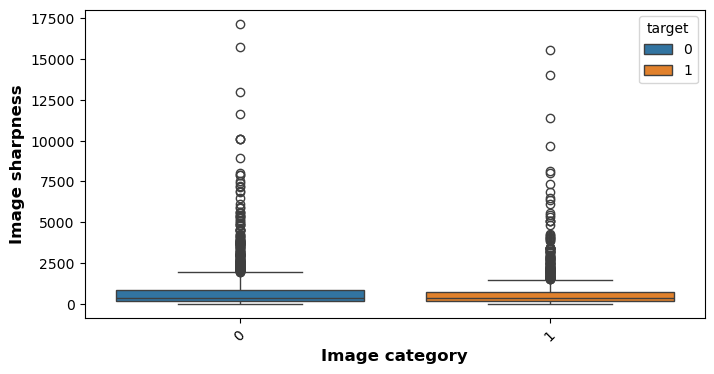

In [51]:
fig, ax = plt.subplots(figsize=(8, 4));
sns.boxplot(data = final_df, x = 'target', y = 'sharpness', hue = 'target',
              ax = ax
             );
plt.xticks(rotation=45);
plt.ylabel('Image sharpness',  fontsize=12, fontweight="bold");
plt.xlabel('Image category',  fontsize=12, fontweight="bold");

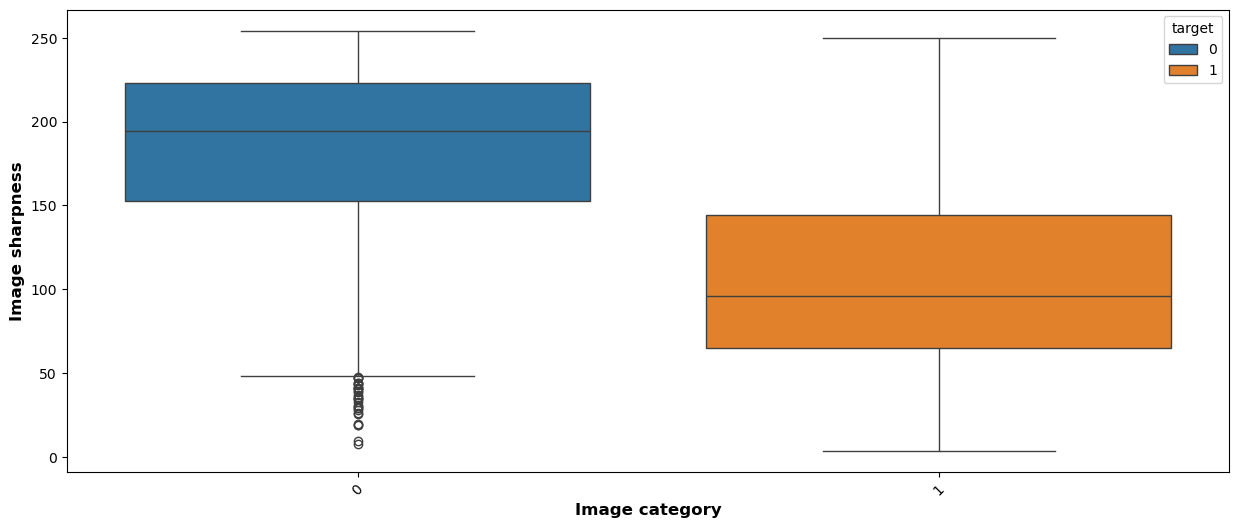

In [52]:
fig, ax = plt.subplots(figsize=(15, 6));
sns.boxplot(data = final_df, x = 'target', y = 'rgb_red', hue = 'target',
              ax = ax
             );
plt.xticks(rotation=45);
plt.ylabel('Image sharpness',  fontsize=12, fontweight="bold");
plt.xlabel('Image category',  fontsize=12, fontweight="bold");

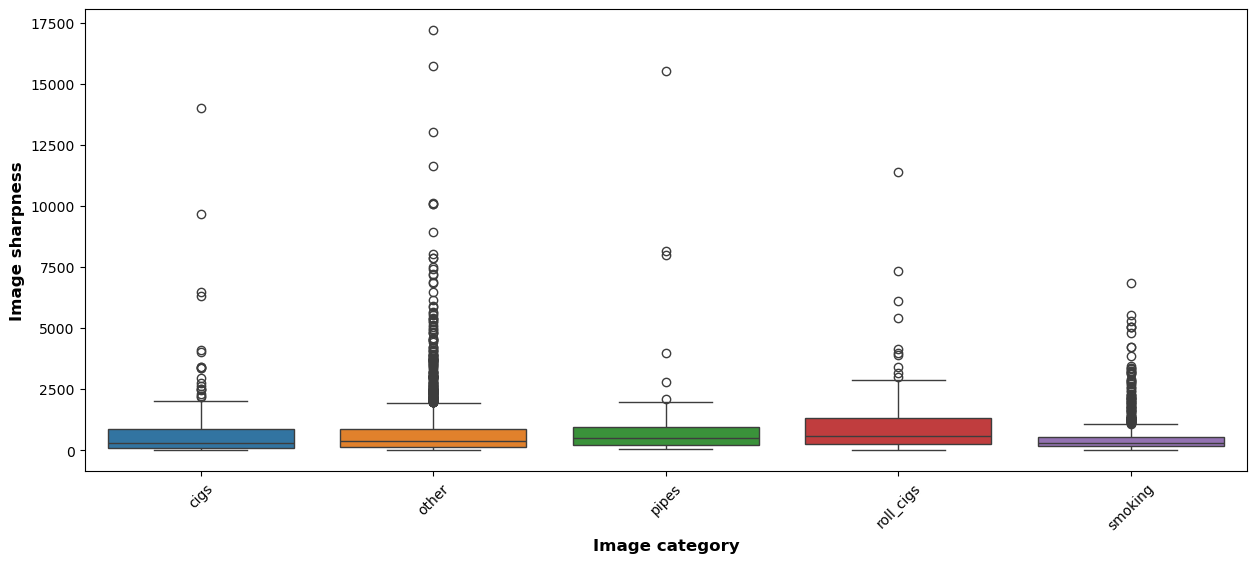

In [21]:
fig, ax = plt.subplots(figsize=(15, 6));
sns.boxplot(data = final_df, x = 'category', y = 'sharpness', hue = 'category',
              ax = ax
             );
plt.xticks(rotation=45);
plt.ylabel('Image sharpness',  fontsize=12, fontweight="bold");
plt.xlabel('Image category',  fontsize=12, fontweight="bold");

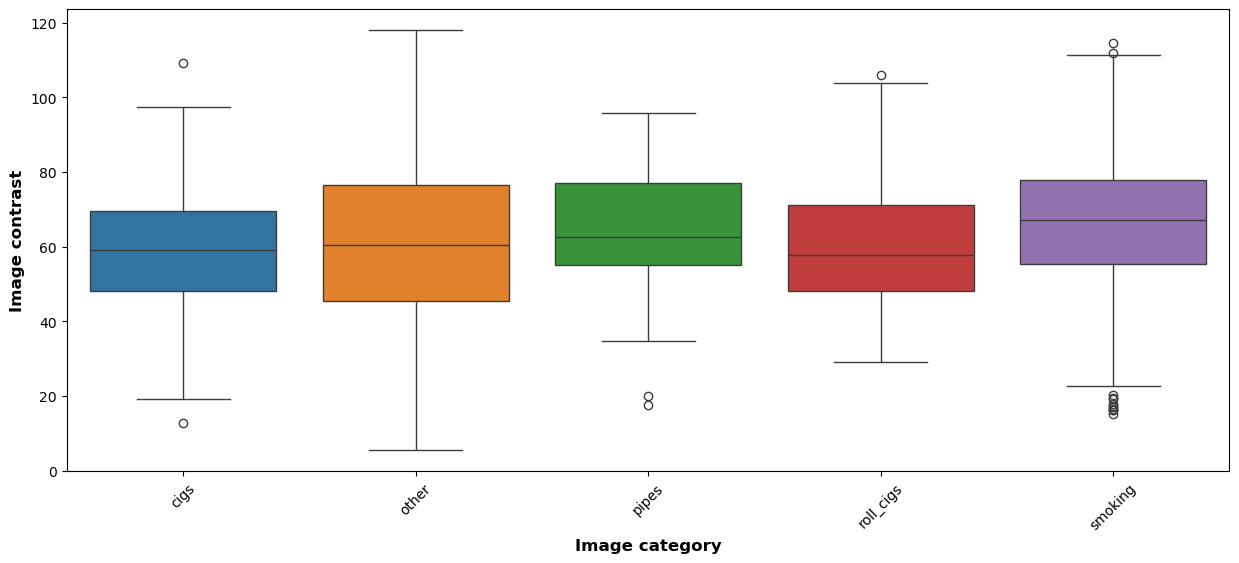

In [22]:
fig, ax = plt.subplots(figsize=(15, 6));
sns.boxplot(data = final_df, x = 'category', y = 'contrast', hue = 'category',
              ax = ax
             );
plt.xticks(rotation=45);
plt.ylabel('Image contrast',  fontsize=12, fontweight="bold");
plt.xlabel('Image category',  fontsize=12, fontweight="bold");

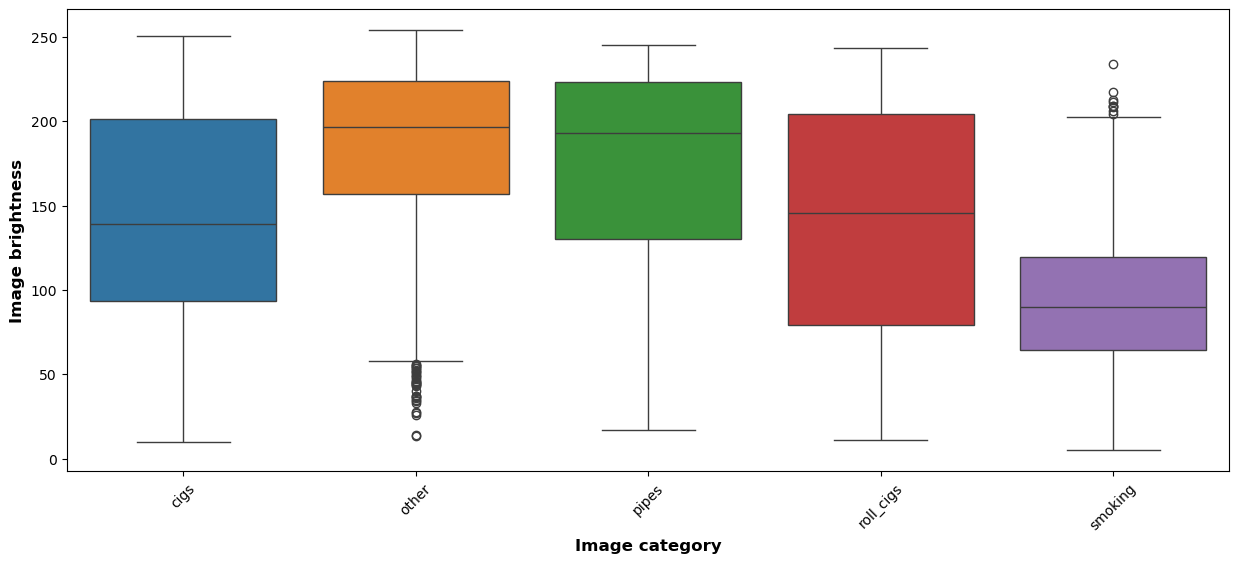

In [23]:
fig, ax = plt.subplots(figsize=(15, 6));
sns.boxplot(data = final_df, x = 'category', y = 'bright', hue = 'category',
              ax = ax
             );
plt.xticks(rotation=45);
plt.ylabel('Image brightness',  fontsize=12, fontweight="bold");
plt.xlabel('Image category',  fontsize=12, fontweight="bold");

In [27]:
final_df[['rgb_red', 'rgb_green', 'rgb_blue']].corr()

,rgb_red,rgb_green,rgb_blue
rgb_red,1.000000,0.966388,0.909299
rgb_green,0.966388,1.000000,0.956810
rgb_blue,0.909299,0.956810,1.000000


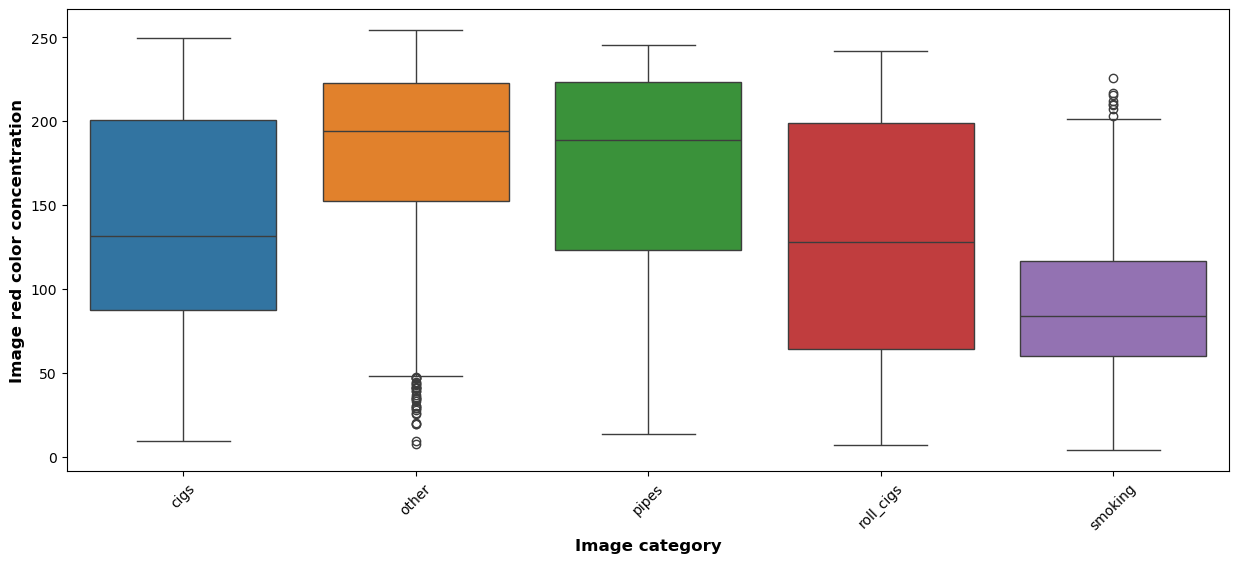

In [35]:
fig, ax = plt.subplots(figsize=(15, 6));
sns.boxplot(data = final_df, x = 'category', y = 'rgb_red', hue = 'category',
              ax = ax
             );
plt.xticks(rotation=45);
plt.ylabel('Image red color concentration',  fontsize=12, fontweight="bold");
plt.xlabel('Image category',  fontsize=12, fontweight="bold");

### Basic classification model on obtained features

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import catboost as cb

In [53]:
final_df.columns

Index(['image_id', 'category', 'sharpness', 'contrast', 'bright', 'rgb_red',
       'rgb_green', 'rgb_blue', 'target'],
      dtype='object')

In [79]:
X = final_df[['sharpness', 'contrast', 'bright', 'rgb_red',
       'rgb_green', 'rgb_blue']]
y = final_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 42, stratify=y )

In [80]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_train, y_train, verbose = False)
y_pred = model.predict(X_test)

precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print("Precision {:.4f}\nRecall {:.4f}\nF1 score {:.4f}".format(precision, recall, f1))

Precision 0.6681
Recall 0.7681
F1 score 0.7146
CPU times: total: 14.5 s
Wall time: 2.35 s


In [81]:
def show_feature_importance(model,
                            X_train,
                            y_train
                           ):
    """
    input : model - catboost model,
            X_train, y_train pandas.DataFrame, fitting sample
    output: plotly barplot 
            pandas.DataFrame() with feature importances
    """
    feature_importance_value = model.get_feature_importance(
    cb.Pool(X_test, y_test))
    feature_importance = {
    "importance" : list(feature_importance_value),
    'feature' : list(X_train.columns)
    }
    feature_importance_df = pd.DataFrame(feature_importance)
    feature_importance_df = feature_importance_df.sort_values('importance', ascending= False)
    
    return feature_importance_df

In [74]:
show_feature_importance(model,
                            X_train,
                            y_train
                           )

,importance,feature
1,21.866224,contrast
5,19.770966,rgb_blue
0,19.744025,sharpness
3,14.785524,rgb_red
4,12.839025,rgb_green
2,10.994235,bright
